### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import json_normalize
import json
import matplotlib.pyplot as plt
import seaborn as sns


### Creating Dataframes

In [3]:
# creating dataframes for the json files

receipts = pd.read_json('data/receipts.json', lines=True)
brands = pd.read_json('data/brands.json', lines=True)
users = pd.read_json('data/users.json', lines=True)

#### Receipts

In [4]:
# get rid of oid and keep id
receipts['_id'] = receipts['_id'].apply(lambda x: x['$oid'])

# change date columns to datetime datatypes

def cast_datetime(df, col):
    ans = []
    for x in df[col].values:
        if type(x) == float:
            ans.append(np.nan)
        else:
            ans.append(pd.to_datetime(datetime.fromtimestamp(x['$date'] // 1000)))
    df[col] = ans
    return df

# listing all date columns to be changed
date_cols = ['createDate', 'dateScanned', 'finishedDate', 'modifyDate', 
             'pointsAwardedDate', 'purchaseDate']

# loop over datetime columns
for col in date_cols:
    receipts = cast_datetime(receipts, col)


#### Items

In [5]:
# exploding the rewardReceiptItemList column
# this column has nested, structured data
# creating a new table called items

items = pd.DataFrame()
items = json_normalize(receipts['rewardsReceiptItemList'].explode().dropna())
items['receiptId'] = receipts.loc[receipts.index.repeat(receipts['rewardsReceiptItemList'].str.len()), '_id'].values


items.head(1)

/Users/deannagould/Documents/Bucks/venv/lib/python3.11/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,userFlaggedNewItem,...,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId,receiptId
0,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5ff1e1eb0a720f0523000575


#### Users

In [6]:
# get rid of oid and keep id
users['_id'] = users['_id'].apply(lambda x: x['$oid'])

# converting values in date columns to datetime datatypes
date_cols = ['createdDate', 'lastLogin']
for col in date_cols:
    users = cast_datetime(users, col)

#### Brands

In [7]:
# get rid of oid and keep id
brands['_id'] = brands['_id'].apply(lambda x: x['$oid'])

# normalizing cpg column in brands
cpg = pd.json_normalize(brands['cpg'])
cpg['_id'] = brands['_id']

# renaming column names so they can be used in sql tables if needed
cpg = cpg.rename(columns={"$ref": "ref", "$id.$oid": "id"})

# dropping original cpg column from brands
brands = brands.drop(columns=['cpg'])  

# pulling cpg back into the df
brands = brands.merge(cpg, on="_id", how="left") 

# dropping the second id column
brands = brands.drop(columns=['id'])

In [8]:
brands.head(1)

,_id,barcode,category,categoryCode,name,topBrand,brandCode,ref
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,test brand @1612366101024,0.0,NaN,Cogs


### Investigating Data Quality

In [9]:
print(receipts.dtypes)

_id                                object
bonusPointsEarned                 float64
bonusPointsEarnedReason            object
createDate                 datetime64[ns]
dateScanned                datetime64[ns]
finishedDate               datetime64[ns]
modifyDate                 datetime64[ns]
pointsAwardedDate          datetime64[ns]
pointsEarned                      float64
purchaseDate               datetime64[ns]
purchasedItemCount                float64
rewardsReceiptItemList             object
rewardsReceiptStatus               object
totalSpent                        float64
userId                             object
dtype: object


In [10]:
print(users.dtypes)

_id                     object
active                    bool
createdDate     datetime64[ns]
lastLogin       datetime64[ns]
role                    object
signUpSource            object
state                   object
dtype: object


In [11]:
print(brands.dtypes)

_id              object
barcode           int64
category         object
categoryCode     object
name             object
topBrand        float64
brandCode        object
ref              object
dtype: object


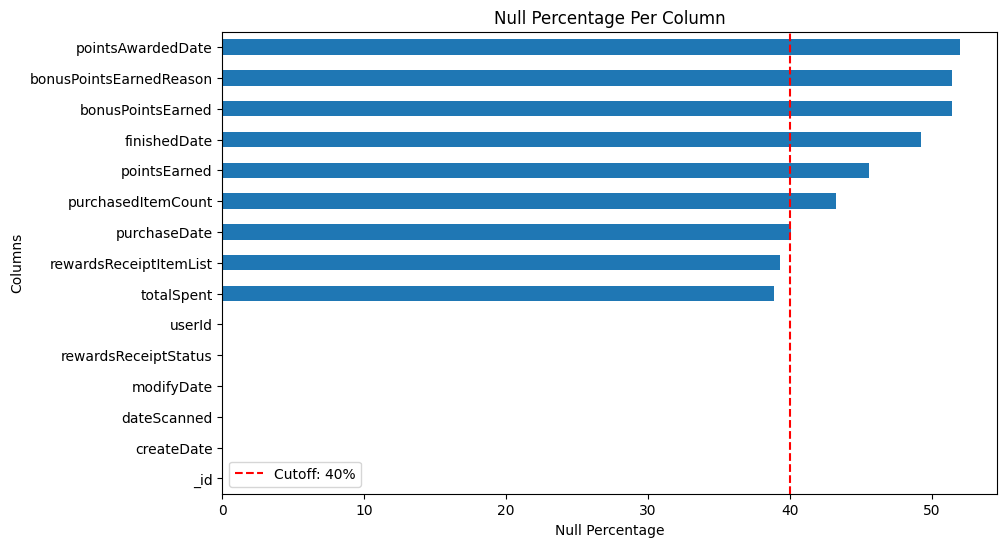

In [12]:
# simply plotting how many null values there are doesn't tell me enough about the df
# creating a function to get the null percentage

def null_percentage_plot(df, cutoff=0, plot_width=10, plot_height=6):
     # Calculate the null percentage for each column
    null_percent = df.isnull().mean() * 100

    # Set up the plot
    plt.figure(figsize=(plot_width, plot_height))
    null_percent.sort_values(ascending=True).plot(kind='barh')

    # Add cutoff line, labels, and title
    plt.axvline(x=cutoff, color='red', linestyle='--', label=f'Cutoff: {cutoff}%')
    plt.xlabel('Null Percentage')
    plt.ylabel('Columns')
    plt.title('Null Percentage Per Column')
    plt.legend()

    # Show the plot
    plt.show()

null_percentage_plot(receipts, cutoff=40, plot_width=10, plot_height=6)
  

In [13]:
def check_outliers(df, col, threshold=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (threshold * IQR)
    upper_bound = Q3 + (threshold * IQR)
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

outliers = check_outliers(receipts, 'pointsEarned')
print(f"Number of outliers: {len(outliers)}")

Number of outliers: 36


### Exporting as CSV's to query with SQL

In [16]:
# exporting dfs to csv's that can be used to query in sql

receipts.to_csv('/Users/deannagould/Documents/Bucks/github/fetch-rewards/csv_files/receipts.csv', index=False)
items.to_csv('/Users/deannagould/Documents/Bucks/github/fetch-rewards/csv_files/items.csv', index=False)
brands.to_csv('/Users/deannagould/Documents/Bucks/github/fetch-rewards/csv_files/brands.csv', index=False)
users.to_csv('/Users/deannagould/Documents/Bucks/github/fetch-rewards/csv_files/users.csv', index=False)